In [2]:
# load the libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from itertools import product


               Close
Date                
2021-01-01  0.005685
2021-01-02  0.010615
2021-01-03  0.009771
2021-01-04  0.009767
2021-01-05  0.009920
...              ...
2022-07-16  0.064280
2022-07-17  0.063107
2022-07-18  0.067715
2022-07-19  0.069013
2022-07-20  0.070945

[566 rows x 1 columns]


<AxesSubplot:xlabel='Date'>

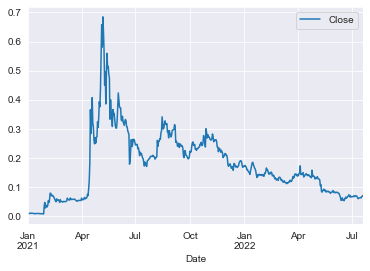

In [4]:
# load the data
df = pd.read_csv('DOGE-USD-daily 2021.csv', header = 0)
df.dropna()
df.head()
close_price = df[["Date", "Close"]].copy()
close_price.index = pd.to_datetime(close_price['Date'])
close_price.drop(columns='Date',inplace=True)
print(close_price)
close_price.plot()

<AxesSubplot:xlabel='Date', ylabel='Resid'>

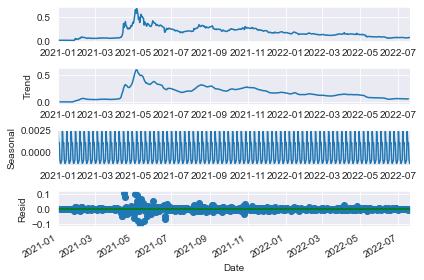

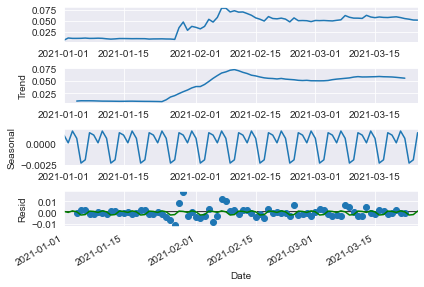

In [5]:
# decompose data
decompose_data = seasonal_decompose(close_price, model="additive")
decompose_data.plot()
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

first_n_row = close_price.iloc[0:84, :1]

decompose_data2 = seasonal_decompose(first_n_row, model="additive")
decompose_data2.plot()
seasonality2=decompose_data2.seasonal
seasonality2.plot(color='green')

The series is stationary


/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


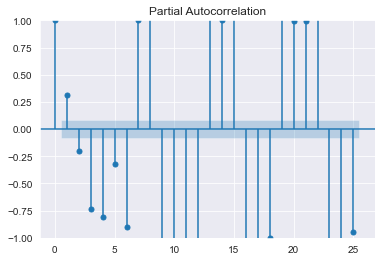

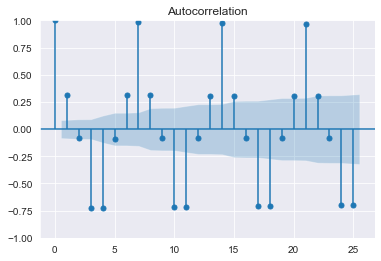

In [6]:
# check stationary
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
check_stationarity(seasonality)
# plot acf, pacf
plot_pacf(seasonality, lags =25)
plt.show()
plot_acf(seasonality, lags =25)
plt.show()

In [7]:
# make the data stationary
ln_close = np.log(close_price)
x0 = ln_close.loc["2022-06-20"]

dftest = adfuller(ln_close.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.940113692022239
2. P-Value :  0.04087823222146368
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 562
5. Critical Values :
	 1% :  -3.442039359113542
	 5% :  -2.8666965134862514
	 10% :  -2.5695162601790758


In [8]:
# split data
m = 30
print(len(ln_close))
train_data = ln_close[0:len(ln_close)-m]
test_data = ln_close[len(ln_close)-m:len(ln_close)]

566


In [30]:
# read exgo varibale data
UDI = pd.read_excel('US Dollar Index.xlsx', index_col=0, header=0)
udi = UDI["UDI"]

BTC = pd.read_excel("BTC-USD.xlsx", index_col=0, header=0)
BTC_Close = BTC["BTC_Close"]

MSCI_ACWI = pd.read_excel('MSCI_AIWC.xlsx', index_col=0, header=0)
MSCI_ACWI = MSCI_ACWI["close"]

COVID_19= pd.read_excel('WHO_ USA_ COVID-19.xlsx', index_col=0, header=0)
YTD = COVID_19["YTD"]
NCC = COVID_19["New_Confirmed_Cases"]

Oil = pd.read_excel('Futures Settlement Price (Continuous)_ Brent Crude Oil.xlsx', index_col=0, header=0)
Brent = Oil["Brent"]

# merge exgo variable data
merge_df = train_data.join(udi)
merge_df["UDI"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(BTC_Close)
merge_df["BTC_Close"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(MSCI_ACWI)
merge_df["close"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(YTD)
merge_df["YTD"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(NCC)
merge_df["New_Confirmed_Cases"].fillna(method='ffill', inplace=True)
merge_df = merge_df.join(Brent)
merge_df["Brent"].fillna(method='ffill', inplace=True)
merge_df.rename(columns = {'close':'MSCI_ACWI'}, inplace = True)
exog_lst = merge_df.iloc[: , 1:]
exog_lst
# find relevant exog variables
model = sm.tsa.statespace.SARIMAX(
    train_data,
    exog=exog_lst,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False, enforce_invertibility=False,
    freq="D").fit(method="powell", disp=False)

model.summary()
# only select BTC_Close

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  536
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood                 444.035
Date:                           Thu, 18 Aug 2022   AIC                           -866.070
Time:                                   18:31:54   BIC                           -819.278
Sample:                               01-01-2021   HQIC                          -847.740
                                    - 06-20-2022                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
UDI                    -0.0089      0.022     -0.408      0.683      -0.052       0.034
BTC_Close            2.365e-05   2.05e-06     11.549      0.000    1.96e-05    2.77e-05
MSCI_ACWI               0.0011      0.001      0.760      0.447      -0.002       0.004
YTD                 -5.771e-09   4.33e-08     -0.133      0.894   -9.07e-08    7.91e-08
New_Confirmed_Cases  1.273e-08   2.03e-07      0.063      0.950   -3.86e-07    4.11e-07
Brent                   0.0002      0.004      0.052      0.959      -0.007       0.008
ar.L1                   0.9804      0.005    197.771      0.000       0.971       0.990
ma.L1                   0.0142      0.025      0.558      0.577      -0.036       0.064
ar.S.L7                 0.0091      0.033      0.275      0.783      -0.056       0.074
ma.S.L7                -1.0491      0.038    -27.429      0.000      -1.124      -0.974
sigma2                  0.0093      0.000     22.130      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             40572.37
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             3.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
p = q = range(0,4)
Ps = Qs = range(0,4)
parameters = product(p, q, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [14]:
# calculate MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
# Tune the model
# grid search to select parameter
def gs_arima(ts, parameters_list, d, Ds, s, opt_method='powell', exog = exog_lst, freq='D'):
    results = []
    best_aic = float("inf")
    for param in parameters_list:
        # we need try-except because on some combinations model might fail to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                ts,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], Ds, param[3], s),
                enforce_stationarity=False, enforce_invertibility=False,
                exog = exog,
                freq=freq).fit(method=opt_method, disp=False)
        except:
            continue

       # choose model with the smallest AIC
        aic = model.aic
        if aic < best_aic:
            better_model = model
            best_aic = aic
            better_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table, better_param, better_model

# merge exgo variable for test_data
merge_df2 = test_data.join(udi)
merge_df2["UDI"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(BTC_Close)
merge_df2["BTC_Close"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(MSCI_AIWC)
merge_df2["close"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(YTD)
merge_df2["YTD"].fillna(method='ffill', inplace=True)
merge_df2 = merge_df2.join(NCC)
merge_df2["New_Confirmed_Cases"].fillna(method='ffill', inplace=True)
merge_df2.rename(columns = {'close':'MSCI_AIWC'}, inplace = True)
merge_df2 = merge_df2.join(Brent)
merge_df2["Brent"].fillna(method='ffill', inplace=True)
exog_test = merge_df2.iloc[: , 1:]

In [ ]:
# tune the model to find the best one
# D = 1
result_table, best_param, best_model =gs_arima(train_data, parameters_list, 0, 1, 7, opt_method='powell',
                                               exog=exog_lst.BTC_Close, freq='D')
print(result_table)
print(best_param)
print(best_model)

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency i

In [26]:
# the best model is (1, 0, 3)*(2, 1, 3, 7)
final_model = sm.tsa.statespace.SARIMAX(
    train_data,
    exog=exog_lst.BTC_Close,
    order=(1, 0, 3),
    seasonal_order=(2, 1, 3, 7),
    enforce_stationarity=False, enforce_invertibility=False,
    freq="D").fit(method="powell", disp=False)

final_model.summary()

/Users/phyllis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  536
Model:             SARIMAX(1, 0, 3)x(2, 1, 3, 7)   Log Likelihood                 573.539
Date:                           Sun, 14 Aug 2022   AIC                          -1125.079
Time:                                   22:18:22   BIC                          -1078.630
Sample:                               01-01-2021   HQIC                         -1106.859
                                    - 06-20-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BTC_Close   2.352e-05    1.8e-06     13.080      0.000       2e-05     2.7e-05
ar.L1          0.9856      0.005    211.076      0.000       0.976       0.995
ma.L1          0.0075      0.030      0.250      0.802      -0.051       0.066
ma.L2          0.0703      0.029      2.395      0.017       0.013       0.128
ma.L3          0.1567      0.030      5.215      0.000       0.098       0.216
ar.S.L7       -1.0993      0.027    -41.448      0.000      -1.151      -1.047
ar.S.L14      -0.6487      0.024    -26.860      0.000      -0.696      -0.601
ma.S.L7        0.2484      0.051      4.866      0.000       0.148       0.349
ma.S.L14      -0.3750      0.053     -7.130      0.000      -0.478      -0.272
ma.S.L21      -0.7117      0.048    -14.827      0.000      -0.806      -0.618
sigma2         0.0059      0.000     27.534      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4926.71
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.012603996504489713
9.449477217401471
90.55052278259853
5.1588549206797236e-05


<AxesSubplot:xlabel='Date'>

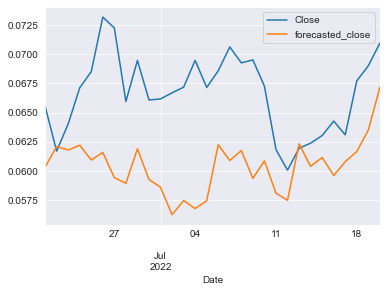

In [15]:
# predict
forecast_ln = final_model.predict(start=536, end=565, exog=exog_test.BTC_Close, dynamic=True)
mse_pre = mean_squared_error(test_data, forecast_ln)
# reverse the prediction
forecasted_close = np.exp(forecast_ln)
# plot the result
test_data2 = close_price[len(ln_close)-m:len(ln_close)]
test_data_df = pd.DataFrame(test_data2)
forecasted_close = pd.DataFrame(forecasted_close)
test_data_df.insert(1, column="forecasted_close", value=forecasted_close)
mape_sarimax = mape(test_data_df.Close, forecasted_close)
mse = mean_squared_error(test_data_df.Close, forecasted_close)
print(mse_pre)
print(mape_sarimax)
print(100-mape_sarimax)
print(mse)
test_data_df[["Close", "forecasted_close"]].plot()

In [30]:
# calculate r2
from sklearn.metrics import r2_score
score = r2_score(test_data_df.Close, forecasted_close)
print("R2 SCORE is", score)

R2 SCORE is -0.2292318299971774
